Plot the surface temperature field from the IBI model (CMEMS)

In [7]:
import os
import glob
import netCDF4
import filament
import datetime
import cmocean
import logging
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from importlib import reload

In [3]:
logger = logging.getLogger("filamentIBIPlot")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 0

In [33]:
reload(filament)

<module 'filament' from '/home/ctroupin/Projects/FNRS-UpwellingFilaments/Filament-Submesoscale/python/filament.py'>

In [4]:
datadir = "/data/CMEMS/IBI/"
figdir = "/data/SST/CapeGhir/figures"
swotfile = "/data/SWOT/swot292_science.txt"
visibledir = "/data/Visible/"
datafilelist = sorted(glob.glob(os.path.join(datadir, "dataset-ibi-analysis-forecast-*.nc")))
nfiles = len(datafilelist)
logger.info("Processing {} files".format(nfiles))

INFO:filamentIBIPlot:Processing 1 files


In [5]:
if not(os.path.exists(figdir)):
    os.makedirs(figdir)

In [9]:
nc.get_variables_by_attributes?

In [6]:
coordinates = (-19., -6., 25., 35.)
m = Basemap(projection='merc', llcrnrlon=coordinates[0], llcrnrlat=coordinates[2],
            urcrnrlon=coordinates[1], urcrnrlat=coordinates[3],
            epsg=4326, resolution='h')

In [42]:
with netCDF4.Dataset(datafilelist[0]) as nc:
    lon = nc.variables["longitude"][:]
    lat = nc.variables["latitude"][:]
    time = nc.variables["time"][:]
    timeunits = nc.variables["time"].units
    dates = netCDF4.num2date(time, timeunits)
    temperature = nc.get_variables_by_attributes(standard_name='sea_water_potential_temperature')[0][:]

In [24]:
sst = filament.SST(lon=lon, lat=lat, field=temperature)

In [30]:
temperature.shape

(4, 1, 1081, 865)

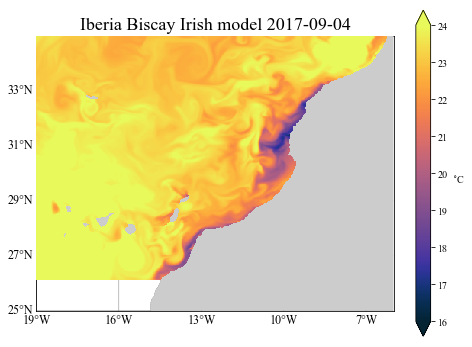

In [44]:
figname = os.path.basename(datafilelist[0]).split(".")[0]
titletext = " ".join(("Iberia Biscay Irish model", dates[0].strftime("%Y-%m-%d")))
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
m.ax = ax
plt.title(titletext, fontsize=18)
pcm = m.pcolormesh(lon, lat, temperature[0,0,:,:], latlon=True,
             cmap=cmocean.cm.thermal, vmin=16., vmax=24., zorder=6)
cb = plt.colorbar(pcm, extend="both", shrink=0.75)
cb.set_label("$^{\circ}$C", rotation=0, ha="left")
#m.drawmapscale(-10., 27.25, -10., 27.25, 100, barstyle='simple',
#               units='km', fontsize=10, fontcolor='k', zorder=5)
m.drawmeridians(np.arange(m.lonmin, m.lonmax, 3.), labels=(0,0,0,1),
                linewidth=.5, fontsize=12, zorder=3)
m.drawparallels(np.arange(m.latmin, m.latmax, 2.), labels=(1,0,0,0),
                linewidth=.5, fontsize=12, zorder=3)
m.fillcontinents(zorder=4)
m.drawcoastlines(linewidth=0.25)
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

'dataset-ibi-analysis-forecast-phys-005-001-daily_1547221078326'

In [68]:
datafilelist2

['/data/SST/GHRSST/20170904140000-OSPO-L2P_GHRSST-SSTskin-VIIRS_NPP-ACSPO_V2.40-v02.0-fv01.0.nc']

In [69]:
for datafile in datafilelist2:
    logger.info(datafile)
    sst = filament.SST()
    sst.read_from_ghrsst(datafile)
    sst.field = np.ma.masked_where(sst.qflag != 5, sst.field)
    
    # Plot without visible
    figname = os.path.join(figdir, sst.get_figname())
    sst.make_plot(m, figname=figname)
    
    # With visible image background
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible")))
    sst.make_plot(m, figname=figname, visibleim=visibleim)
    
    # With visible image background and SWOT
    swot = filament.Swot()
    swot.read_from(swotfile)
    swot.select_domain(coordinates)
    visiblefile = os.path.join(visibledir, "VIIRS_{}.tiff".format(sst.date.strftime("%Y%m%d")))
    if os.path.exists(visiblefile):
        visibleim = filament.Visible()
        visibleim.read_from(visiblefile)
        visibleim.extract_area(coordinates)
    figname = os.path.join(figdir, "_".join((sst.get_figname(), "visible", "swot")))
    sst.make_plot(m, figname=figname, visibleim=visibleim, swot=swot)

INFO:filamentPlot:/data/SST/GHRSST/20170904140000-OSPO-L2P_GHRSST-SSTskin-VIIRS_NPP-ACSPO_V2.40-v02.0-fv01.0.nc
